In [2]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns

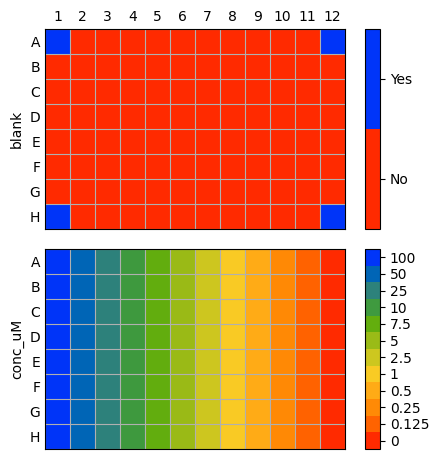

In [3]:
# wellmap.show("2 substance 1 plate.toml")
wellmap.show("RZ_12_concentrations.toml"); # Yes, this semicolon is meaningful. Or plates map will be duplicated

Index(['ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed'],
      dtype='object')


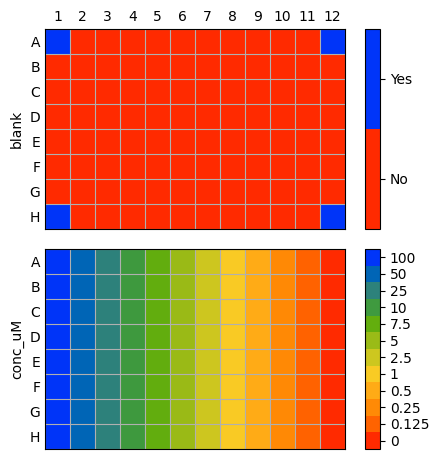

In [35]:
path_to_data = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-17 RD Slovesnova CK122 24H\ExpWells_plate.csv"
path_to_wellmap = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-17 RD Slovesnova CK122 24H\RZ_12_concentrations.toml"

data_raw = pd.read_csv(path_to_data) 

print(data_raw.columns)
wellmap.show(path_to_wellmap);
# print(data)


In [36]:
data = data_raw[['Intensity_IntegratedIntensity_OrigGreen','Intensity_IntegratedIntensity_OrigRed','Intensity_MeanIntensity_OrigGreen','Intensity_MeanIntensity_OrigRed']].copy()
print(data)

    Intensity_IntegratedIntensity_OrigGreen  \
0                                 63.819610   
1                                151.486278   
2                                139.698043   
3                                150.780396   
4                                153.517651   
..                                      ...   
91                               524.486287   
92                               437.349033   
93                               452.482365   
94                               452.572562   
95                                93.011768   

    Intensity_IntegratedIntensity_OrigRed  Intensity_MeanIntensity_OrigGreen  \
0                              342.741186                           0.011610   
1                              305.721576                           0.027558   
2                              338.611779                           0.025414   
3                              332.278445                           0.027430   
4                              351.

In [37]:
row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))

row_column_list = []

for c in column:
    for r in row:
        array_i = [r,c]
        row_column_list.append(array_i)


# print(row_column_list)


row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

   row  col
0    A    1
1    B    1
2    C    1
3    D    1
4    E    1
..  ..  ...
91   D   12
92   E   12
93   F   12
94   G   12
95   H   12

[96 rows x 2 columns]


In [38]:

data_indexed = pd.concat([row_column_df, data], axis=1, join='inner')


data_indexed['col']=data_indexed['col'].astype(str)
print(data_indexed)

   row col  Intensity_IntegratedIntensity_OrigGreen  \
0    A   1                                63.819610   
1    B   1                               151.486278   
2    C   1                               139.698043   
3    D   1                               150.780396   
4    E   1                               153.517651   
..  ..  ..                                      ...   
91   D  12                               524.486287   
92   E  12                               437.349033   
93   F  12                               452.482365   
94   G  12                               452.572562   
95   H  12                                93.011768   

    Intensity_IntegratedIntensity_OrigRed  Intensity_MeanIntensity_OrigGreen  \
0                              342.741186                           0.011610   
1                              305.721576                           0.027558   
2                              338.611779                           0.025414   
3                  

In [39]:
labels = wellmap.load(path_to_wellmap)
# print(labels.dtypes)
# print(data_indexed.dtypes)


data_plate = pd.merge(data_indexed, labels)
print(labels)

   well well0 row col  row_i  col_j blank conc_uM
0    A1   A01   A   1      0      0   Yes     100
1    H1   H01   H   1      7      0   Yes     100
2   A12   A12   A  12      0     11   Yes       0
3   H12   H12   H  12      7     11   Yes       0
4    A2   A02   A   2      0      1    No      50
..  ...   ...  ..  ..    ...    ...   ...     ...
91   H7   H07   H   7      7      6    No     2.5
92   H8   H08   H   8      7      7    No       1
93   H9   H09   H   9      7      8    No     0.5
94  H10   H10   H  10      7      9    No    0.25
95  H11   H11   H  11      7     10    No   0.125

[96 rows x 8 columns]


Cleaning


In [42]:
blank_green = data_plate[(data_plate['blank'] == 'Yes')].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
control_green = data_plate[(data_plate['conc_uM'] == '0')].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

data_plate_wo_blank = data_plate[data_plate.blank == 'No'].copy()

data_plate_wo_blank['Green'] = data_plate_wo_blank['Intensity_MeanIntensity_OrigGreen'] - blank_green


data_plate_wo_blank['Green_relative'] = data_plate_wo_blank['Green']/control_green*100



Drop outliers

In [114]:
well_drop_list = ['H4','H5','H6','G4','G5']

data_plate_wo_blank = data_plate_wo_blank[~data_plate_wo_blank['well'].isin(well_drop_list)]

df_show = data_plate_wo_blank.loc[(data_plate_wo_blank['sample'] == 'Substance_1') & (data_plate_wo_blank['conc_uM'] == '100')]

print(df_show[['Green_relative','well']])


    Green_relative well
1         0.160628   B1
8         0.099118   A2
10        0.069768   C2
11        0.089928   D2
16        0.140389   A3
17        0.079662   B3
18        0.092048   C3


Plotting


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


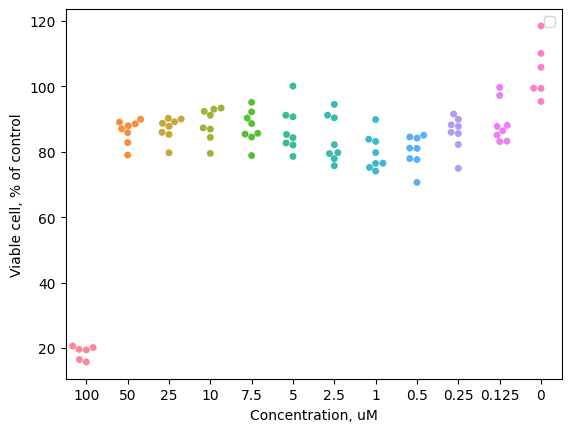

In [48]:
# sns.swarmplot(data=data_plate_wo_blank, x="conc_uM", y="Intensity_MeanIntensity_OrigGreen", hue='sample')
ax = sns.swarmplot(data=data_plate_wo_blank, x="conc_uM", y="Green_relative")

ax.set(xlabel='Concentration, uM', ylabel='Viable cell, % of control')


handles, labels = ax.get_legend_handles_labels()
labels = []
ax.legend(handles=handles, labels=labels)
